Number of calibration Images=20

              ******************************  CALIBRATION IMAGES:*****************************



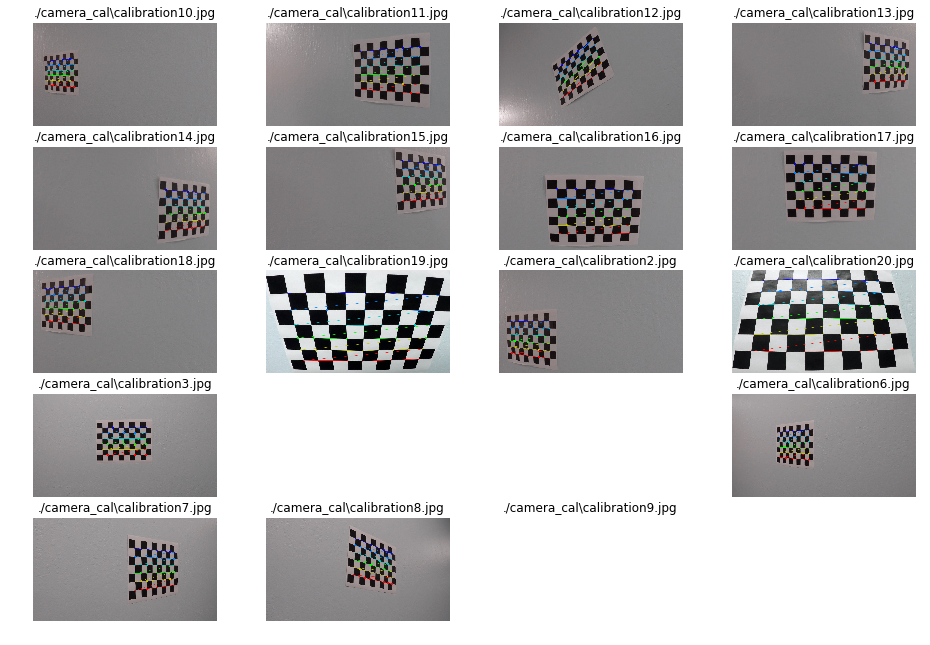

In [62]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
# prepare object points
nx = 8
ny = 6


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

plt.figure(figsize=(16, 11))

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
calib_images = glob.glob('./camera_cal/calibration*.jpg')
print("Number of calibration Images="+ str(len(calib_images)))
#Iterate over the list containing the file names of the calibration Images:
for i, File_name in enumerate(calib_images):
    color_img = cv2.imread(File_name)
    gray_img = cv2.cvtColor(color_img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_img, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        # Draw and display the corners
        img = cv2.drawChessboardCorners(color_img, (9,6), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.imshow(img)
        plt.subplot(5, 4, i)
        plt.title(File_name)
        plt.axis('off')
print("\n              ******************************  CALIBRATION IMAGES:*****************************\n")
plt.show()

        
       

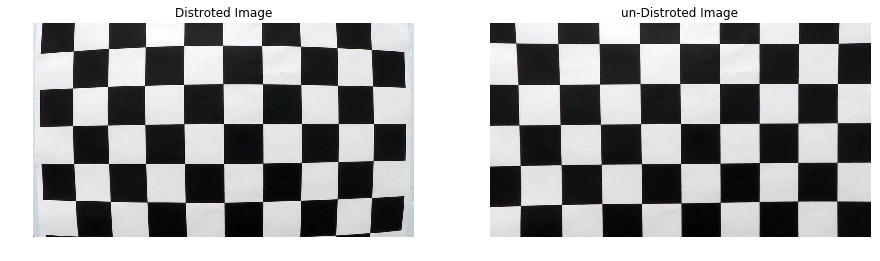

In [63]:
import pickle
# Load the un-distorted image
dist_image = cv2.imread('./camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (dist_image.shape[1], dist_image.shape[0]),None,None)
un_dist_image = cv2.undistort(dist_image, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

# Visualize undistortion
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(dist_image)
axarr[0].set_title('Distroted Image')
axarr[0].axis('off')
axarr[1].imshow(un_dist_image)
axarr[1].set_title('un-Distroted Image')
axarr[1].axis('off')
plt.show()


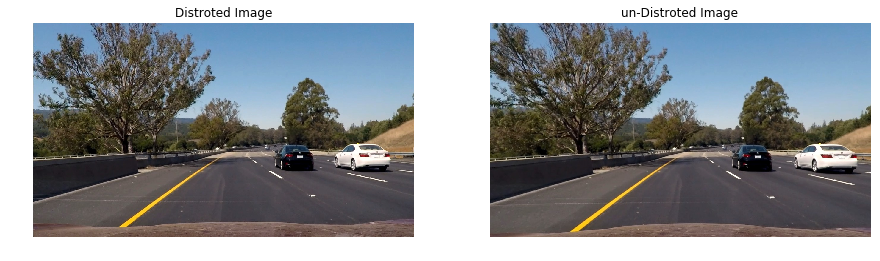

In [64]:
import pickle

# undistort image using camera calibration matrix from above
def undistort(img):
    # Read the saved camera calibration used to un-distort images out of the camera 
    dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

dist_image = cv2.imread('./test_images/test6.jpg')
dist_image = cv2.cvtColor(dist_image, cv2.COLOR_BGR2RGB)
undist_image=undistort(dist_image)


# Visualize undistortion
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(dist_image)
axarr[0].set_title('Distroted Image')
axarr[0].axis('off')
axarr[1].imshow(undist_image)
axarr[1].set_title('un-Distroted Image')
axarr[1].axis('off')
plt.show()

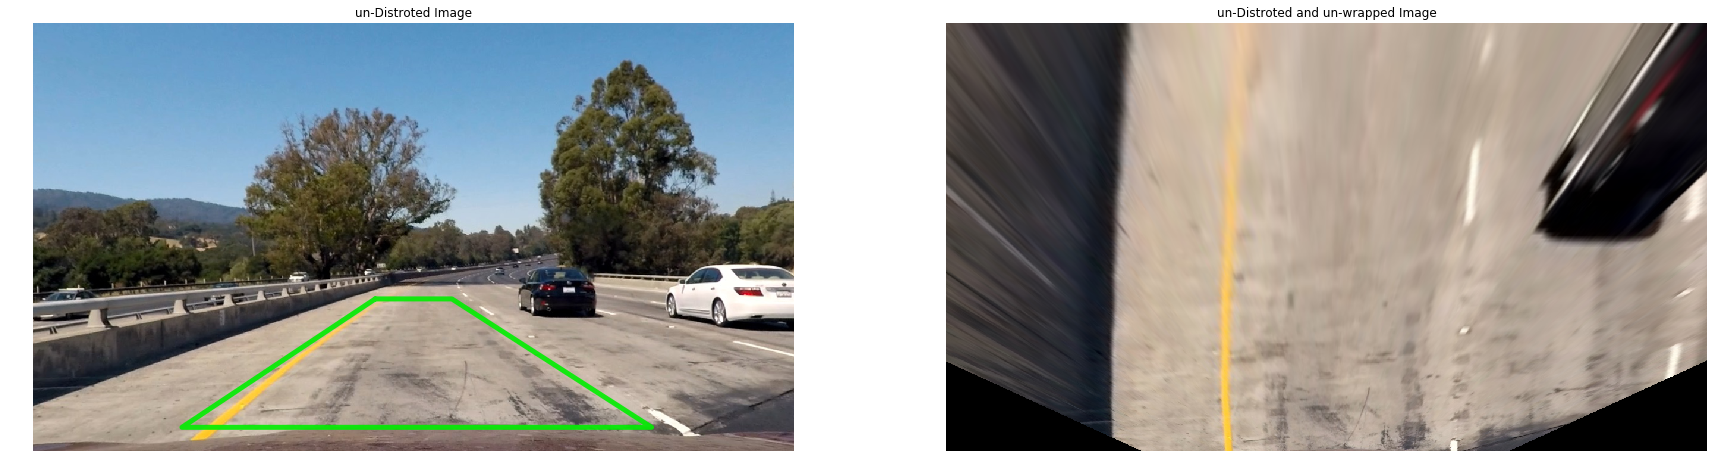

In [117]:
import pickle
from ipywidgets import interact, interactive, fixed

def load_and_undistort(img):
        dist_image = cv2.imread(img)
        dist_image = cv2.cvtColor(dist_image, cv2.COLOR_BGR2RGB)
        undist_image=undistort(dist_image)
        return undist_image
def load_image(image_name):
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

def unwarp(img):
    h,w = img.shape[:2]
    dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
    M = dist_pickle["M"]
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped

def display_unwrap_wrap(dest_image,un_wrap_image,src_pts):
    x = [src_pts[0][0],src_pts[2][0],src_pts[3][0],src_pts[1][0],src_pts[0][0]]
    y = [src_pts[0][1],src_pts[2][1],src_pts[3][1],src_pts[1][1],src_pts[0][1]]
    # Visualize undistortion
    image=np.copy(image)
    f, axarr = plt.subplots(1,2,figsize=(30,30))
    axarr[0].imshow(dest_image)
    axarr[0].plot(x, y, color='#00EE00', alpha=0.9, linewidth=5, solid_capstyle='round', zorder=2)
    axarr[0].set_title('un-Distroted Image')
    axarr[0].axis('off')
    axarr[1].imshow(un_wrap_image)
    axarr[1].set_title('un-Distroted and un-wrapped Image')
    axarr[1].axis('off')
    plt.show()
    
    
    



# define source and destination points for transform
src_pts = np.float32([(575,464),
                  (704,464), 
                  (250,680), 
                  (1040,680)])
dst_pts = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

# use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)

#pickle the  transformation matrix
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
dist_pickle["M"]= M
dist_pickle["Minv"]= Minv
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )


dest_image=load_and_undistort('./test_images/test1.jpg')

un_wrap_image= unwarp(dest_image)

display_unwrap_wrap(dest_image,un_wrap_image,src_pts)





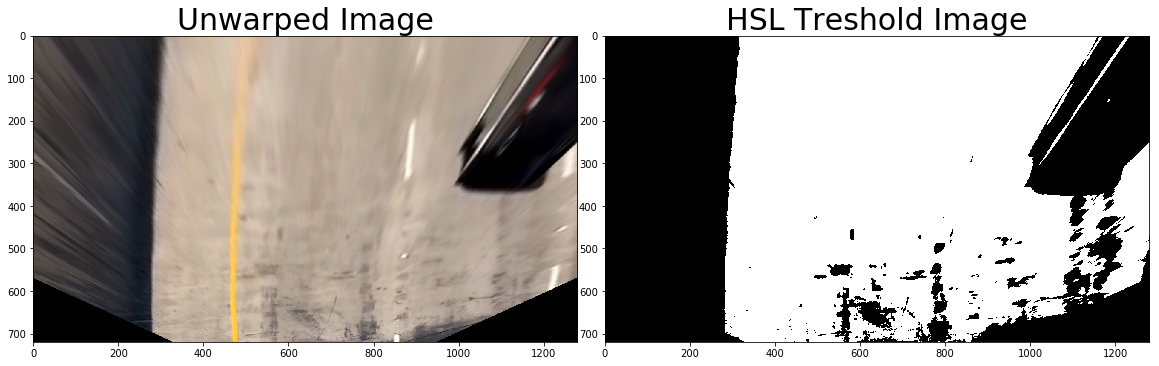

In [112]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def update(min_thresh, max_thresh):
    exampleImg_sobelAbs = hls_lthresh(un_wrap_image,( min_thresh, max_thresh))
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(un_wrap_image)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelAbs, cmap='gray')
    ax2.set_title('HSL Treshold Image', fontsize=30)
    plt.show()

interact(update, min_thresh=(0,255), max_thresh=(0,255))



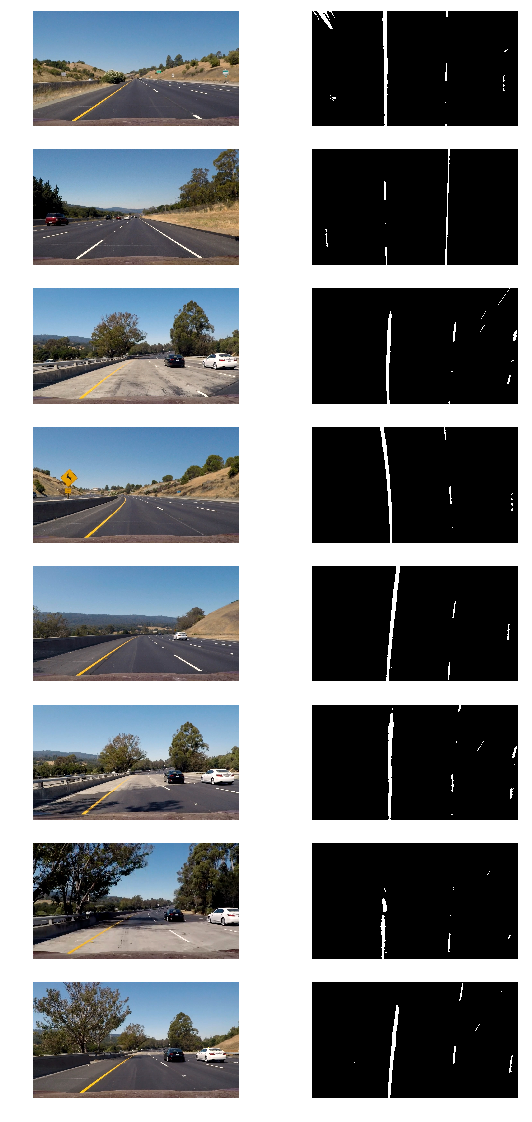

In [163]:
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp = unwarp(img_undistort)


    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined


# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axis = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axis = axis.ravel()
                  
i = 0
for image in images:
    img = load_image(image)
    img_bin = pipeline(img)
    axis[i].imshow(img)
    axis[i].axis('off')
    i += 1
    axis[i].imshow(img_bin, cmap='gray')
    axis[i].axis('off')
    i += 1
plt.show()


C:\Users\raghavender.yadagiri\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """


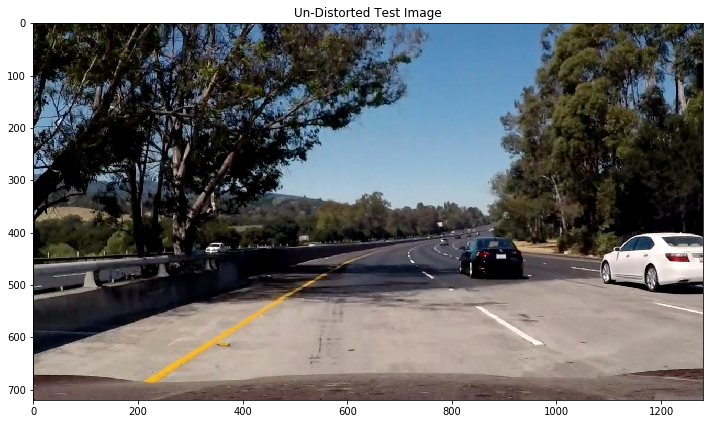

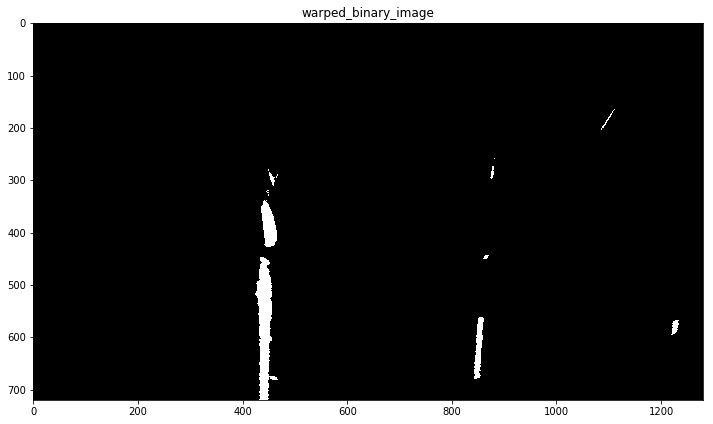

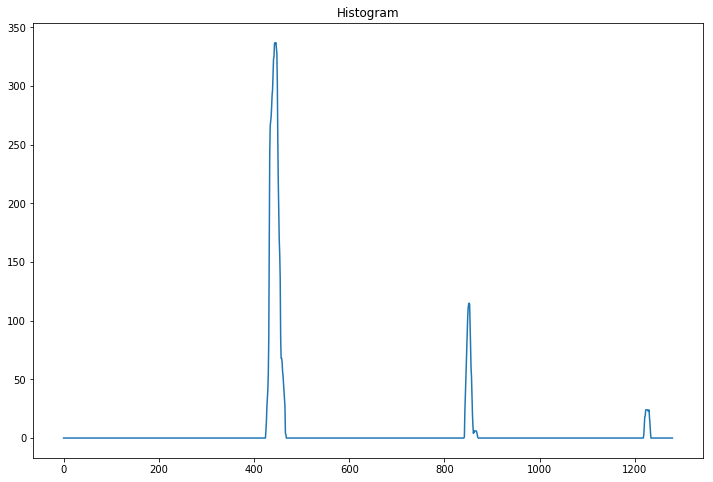

In [254]:
img = load_image('./test_images/test5.jpg')
binary_warped = pipeline(img)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.figure(figsize=(12, 8))
plt.title("Un-Distorted Test Image")
plt.imshow(img)
plt.figure(figsize=(12, 8))
plt.title("warped_binary_image")
plt.imshow(binary_warped ,cmap='gray')
plt.figure(figsize=(12, 8))
plt.title("Histogram")
plt.plot(histogram)
plt.show()

In [255]:
# we Find the midpoint on the histogram 
midpoint = np.int(histogram.shape[0] / 2)
print("Midpoint on the Histogram=",midpoint)
# Now we calculate the peaks on the left and right half of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("Midpoint on left half(x location for left lane)=",leftx_base)
print("Midpoint on right half(x location for Right lane)=",rightx_base)


Midpoint on the Histogram= 640
Midpoint on left half(x location for left lane)= 444
Midpoint on right half(x location for Right lane)= 852


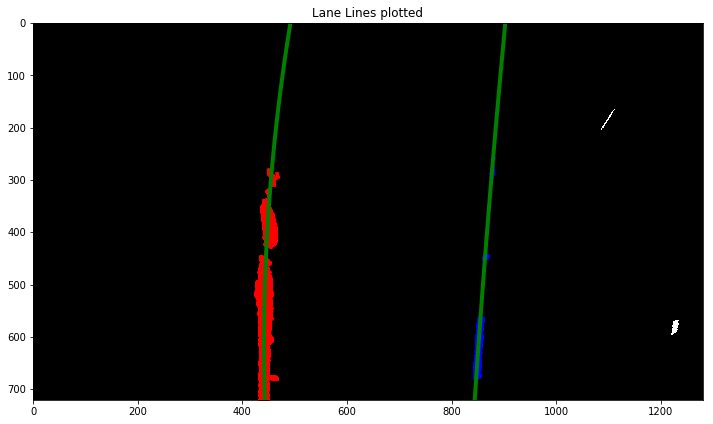

In [263]:
# Now we need to calulate number of boxes we need to implement sliding window
# Also we need the x and y pixcel locations of the left and right lane.
def Find_Lanes_Sliding_window(binary_warped):
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0] / nwindows)


    #now we extract the X and Y pixcels of the lane locations(non zero locaations)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set current x coordinated for left and right
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 75
    min_num_pixels = 35

    # save pixel ids in these two lists
    left_lane_inds = []
    right_lane_inds = []
    warped_image=binary_warped

    for window in range(nwindows):
        win_y_low = warped_image.shape[0] - (window + 1) * window_height
        win_y_high = warped_image.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > min_num_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_num_pixels:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the ndarrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    fity = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
    fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,binary_warped,leftx,lefty,rightx,righty

left_fit,right_fit,left_lane_inds,right_lane_inds,binary_warped,leftx,lefty,rightx,righty=Find_Lanes_Sliding_window(binary_warped)
plt.figure(figsize=(12, 8))
plt.imshow(warped_image,cmap='gray')
plt.title("Lane Lines plotted")
plt.plot(leftx, lefty, 'o', color='red', markersize=2)
plt.plot(rightx, righty, 'o', color='blue', markersize=2)
plt.plot(fit_leftx, fity, color='green',linewidth=4.0)
plt.plot(fit_rightx, fity, color='green',linewidth=4.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


In [264]:

#Now that we have the Left lane and Right Lane points now we need to calculate the radious of curvature of the lanes.
def compute_curveature(left_fit,right_fit,left_lane_inds,right_lane_inds,binary_warped,leftx,lefty,rightx,righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = 719
    h = binary_warped.shape[0]

    
 
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    
    return left_curverad,right_curverad,center_dist

    
    
left_curverad,right_curverad,center_dist=compute_curveature(left_fit,right_fit,left_lane_array,right_lane_array,binary_warped,leftx,lefty,rightx,righty)

print(left_curverad, 'm', right_curverad, 'm')
print('Distance from lane center :', center_dist, 'm')
    

1229.72089616 m 8292.33749963 m
Distance from lane center : -0.0189474932436 m


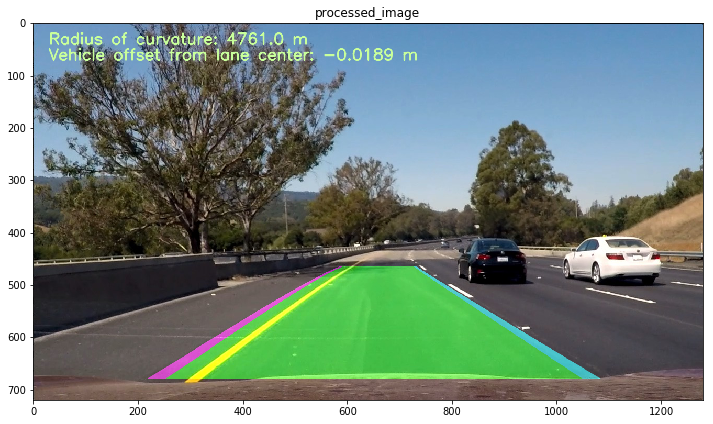

In [299]:
def draw_lane(original_img, binary_img, left_fit, right_fit,Minv):
    
    new_img = np.copy(original_img)
    if left_fit is None or right_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h = binary_warped.shape[0]
    w = binary_warped.shape[1]
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
Minv=dist_pickle["Minv"]

def draw_text(processed_image,left_curverad,right_curverad,center_dist):
    result = np.copy(processed_image)
    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_curverad + right_curverad)/2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(processed_image, label_str, (30,40), 0, 1, (200,255,155), 2, cv2.LINE_AA)

    label_str = 'Vehicle offset from lane center: %.4f m' % center_dist
    result = cv2.putText(processed_image, label_str, (30,70), 0, 1, (200,255,155), 2, cv2.LINE_AA)
    return result

processed_image=draw_lane(img, binary_warped, left_fit, right_fit,Minv)
processed_image=draw_text(processed_image,left_curverad,right_curverad,center_dist)

plt.figure(figsize=(12, 8))
plt.imshow(processed_image)
plt.title("processed_image")
plt.show()

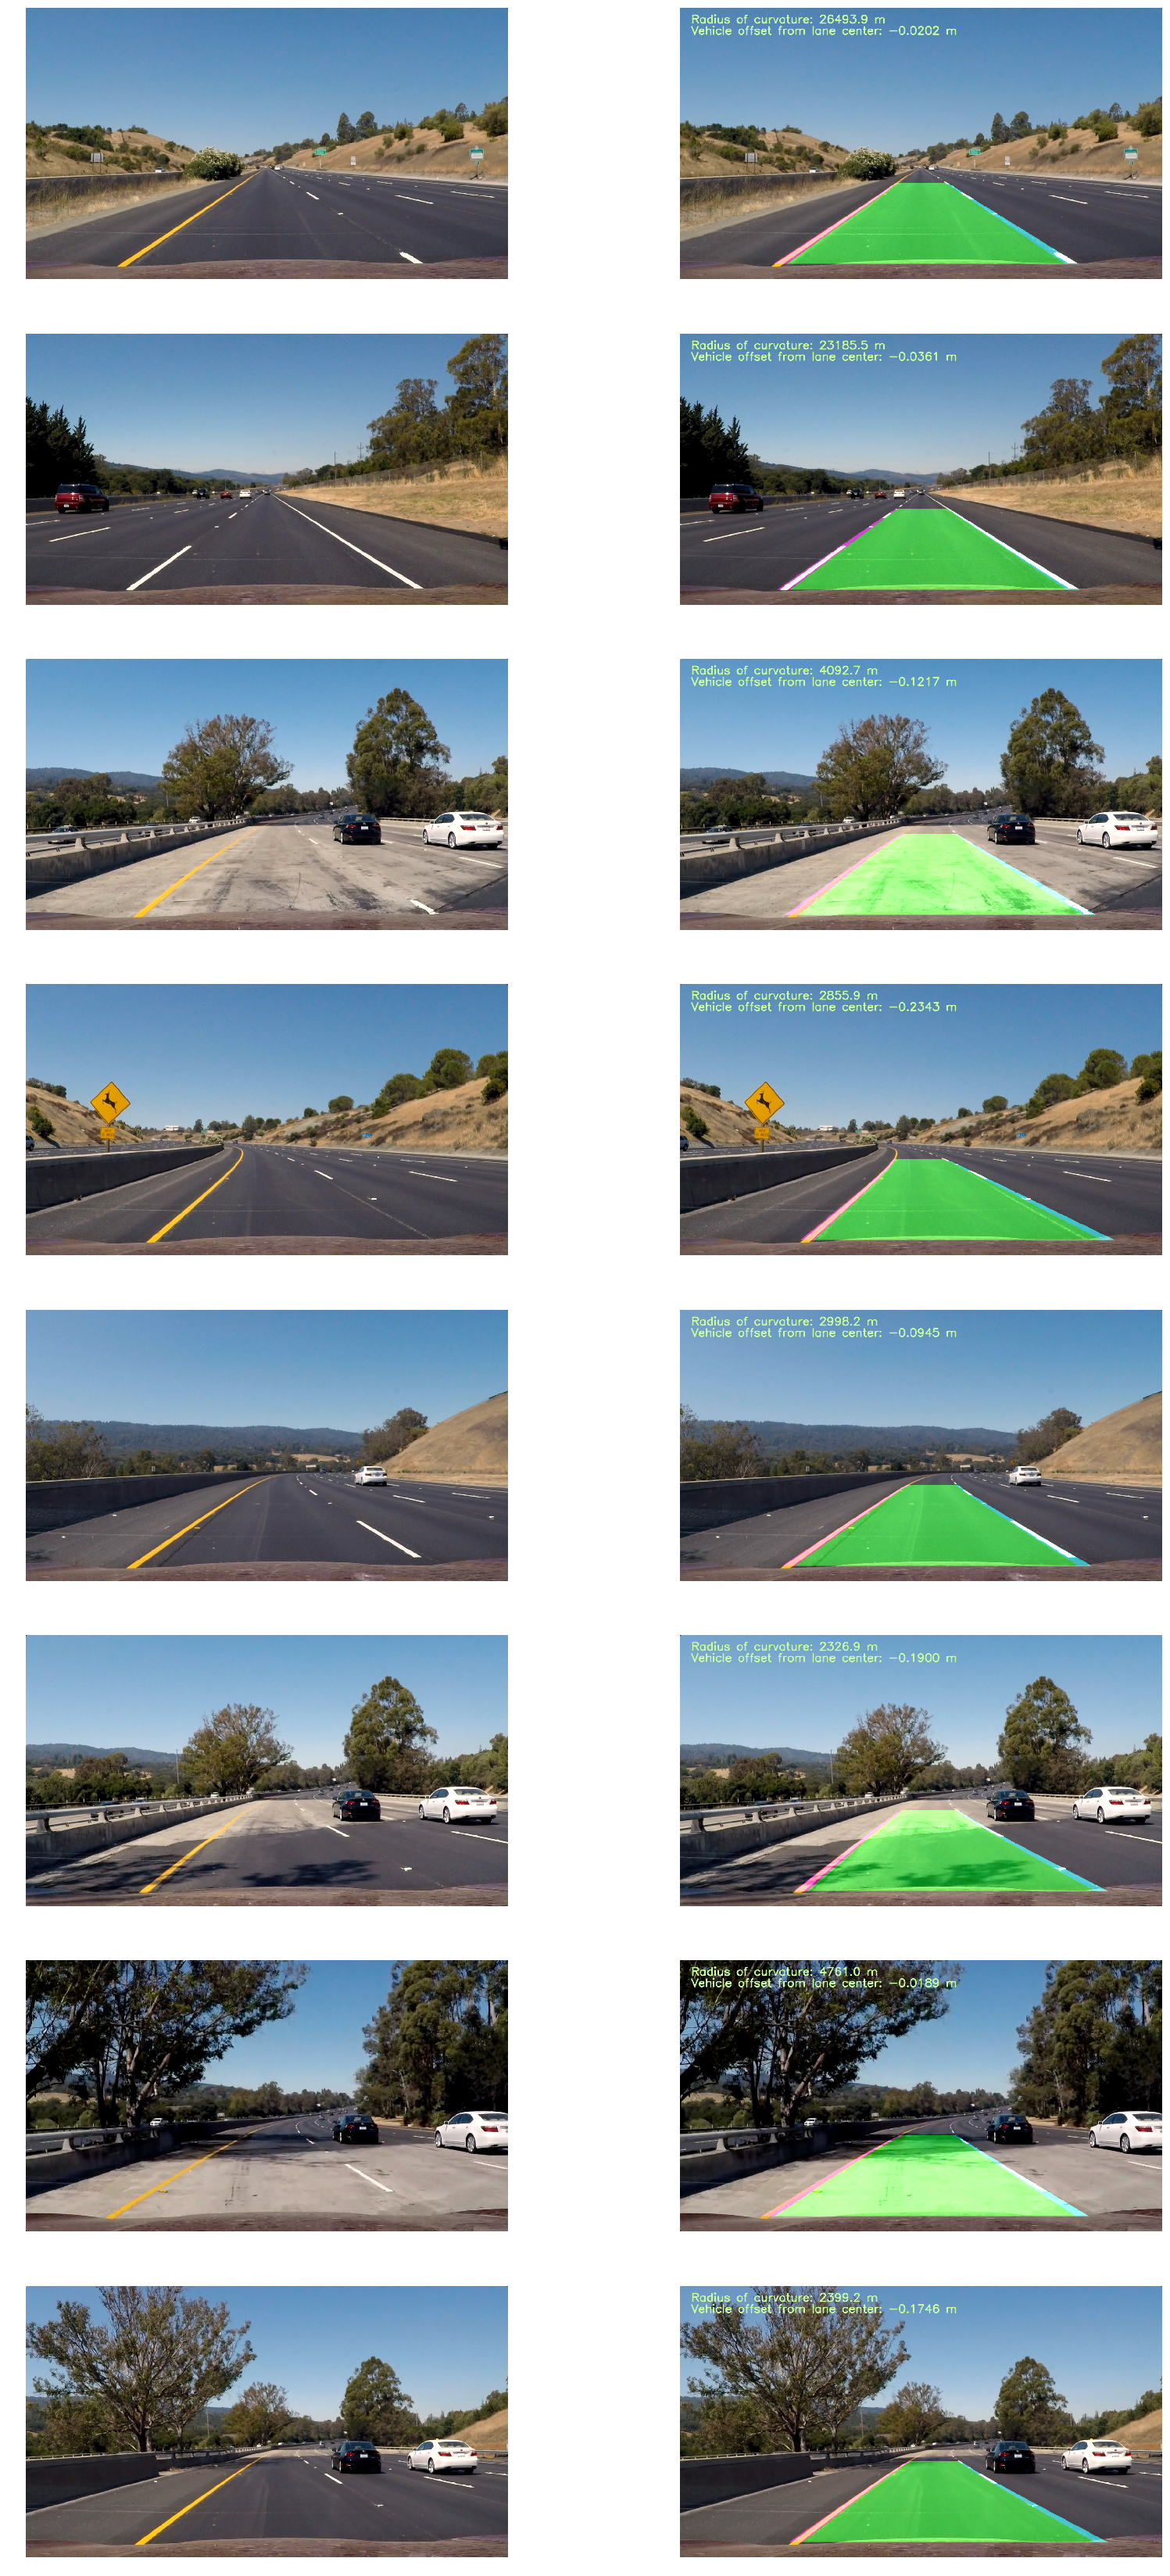

In [295]:
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
Minv=dist_pickle["Minv"]

def prosess_image(image):
    binary_warped=pipeline(image)# un-dsitort un-wrap and treshold
    
    #find lane attributes using Sliding window technique 
    left_fit,right_fit,left_lane_inds,right_lane_inds,binary_warped,leftx,lefty,rightx,righty=Find_Lanes_Sliding_window(binary_warped)
    
    
    #compute Lane curvature and vehicle distance form the center
    left_curverad,right_curverad,center_dist=compute_curveature(left_fit,right_fit,left_lane_array,right_lane_array,binary_warped,leftx,lefty,rightx,righty)
    
    #oveelay lane and text on the original image
    processed_image=draw_lane(image, binary_warped, left_fit, right_fit,Minv)
    processed_image=draw_text(processed_image,left_curverad,right_curverad,center_dist)
    
    return processed_image

    


# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axis = plt.subplots(len(images),2, figsize=(30,60))
fig.subplots_adjust(hspace = .2 ,wspace=0)
axis = axis.ravel()
                  
i = 0
for image in images:    
    img = load_image(image)    
    processed_image=prosess_image(img)
    axis[i].imshow(img)
    axis[i].axis('off')
    i += 1
    axis[i].imshow(processed_image, cmap='gray')
    axis[i].axis('off')
    i += 1
plt.show()



In [298]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def Process_video(input_file, output_file):
    video = VideoFileClip(input_file)
    annotated_video = video.fl_image(prosess_image)
    %time annotated_video.write_videofile(output_file, audio=False)

Process_video("project_video.mp4","out.mp4")    

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:14<00:00,  9.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

Wall time: 2min 14s
